In [1]:
import numpy as np
from tensorflow import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

2025-05-26 16:38:51.861284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 16:38:51.918141: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 16:38:52.099368: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 16:38:52.153862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748277532.213359    6084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748277532.24

In [2]:
np.random.seed(20)


In [3]:
import os, gdown
from scipy.io import loadmat

# e.g. store in /tmp or ../data
cache_dir = "/tmp/svhn_data"
os.makedirs(cache_dir, exist_ok=True)

gdown.download("https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb",
               os.path.join(cache_dir, "train_32x32.mat"), quiet=False)
gdown.download("https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv",
               os.path.join(cache_dir, "test_32x32.mat"), quiet=False)

train_raw = loadmat(os.path.join(cache_dir, "train_32x32.mat"))
test_raw  = loadmat(os.path.join(cache_dir, "test_32x32.mat"))


Downloading...
From (original): https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb
From (redirected): https://drive.google.com/uc?id=1FSwCLJzPzL4ZmihRgjIkh3DImRwM0UHb&confirm=t&uuid=7db6e407-1c61-4cdc-b715-817718a8ba93
To: /tmp/svhn_data/train_32x32.mat
100%|██████████| 182M/182M [00:04<00:00, 44.8MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv
From (redirected): https://drive.google.com/uc?id=10E7i5m1HaGWZkte4P8WMouNoFj0dFHmv&confirm=t&uuid=52b28dc9-919b-4506-8d56-d9028df0a8b3
To: /tmp/svhn_data/test_32x32.mat
100%|██████████| 64.3M/64.3M [00:00<00:00, 90.2MB/s]


In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


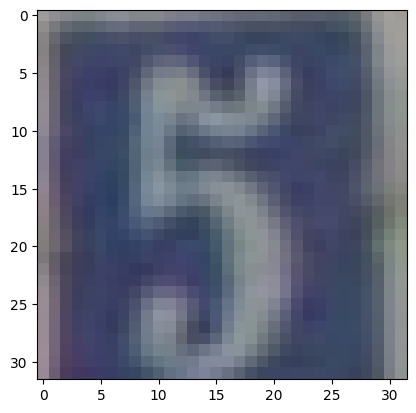

Label:  [5]


In [7]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [8]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [9]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [11]:
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0


In [12]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [13]:
# Split train data into train and validation sets

# Just try splitting the first 1000 samples for debugging
X_train, X_val, y_train, y_val = train_test_split(train_images[:1000], train_labels[:1000],
                                                  test_size=0.15, random_state=22)


In [14]:
y_val.shape

(150, 10)

In [15]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In [16]:
# Before training: set up a list + callback to log the LR
lrs = []

class LRTLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # grab the current learning rate from the optimizer and append it
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        lrs.append(lr)

In [17]:
# Define auxillary model

keras.backend.clear_session()

aux_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-26 16:39:17.355728: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
# Fit model in order to determine best learning rate
lr_logger = LRTLogger()

history = aux_model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule, lr_logger])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.1001 - loss: 3.5184 - val_accuracy: 0.2333 - val_loss: 2.2971 - learning_rate: 1.0000e-04
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.1515 - loss: 2.9285 - val_accuracy: 0.2400 - val_loss: 2.2952 - learning_rate: 1.2589e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.1615 - loss: 2.6649 - val_accuracy: 0.2400 - val_loss: 2.2928 - learning_rate: 1.5849e-04
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.1253 - loss: 2.4359 - val_accuracy: 0.2400 - val_loss: 2.2919 - learning_rate: 1.9953e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.1525 - loss: 2.3162 - val_accuracy: 0.2400 - val_loss: 2.2926 - learning_rate: 2.5119e-04
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.1362 - loss: 2.3017 - val_accuracy: 0.2400 - val_loss: 2.2896 - learning_rate: 3.1623e-04
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.1425 - loss:

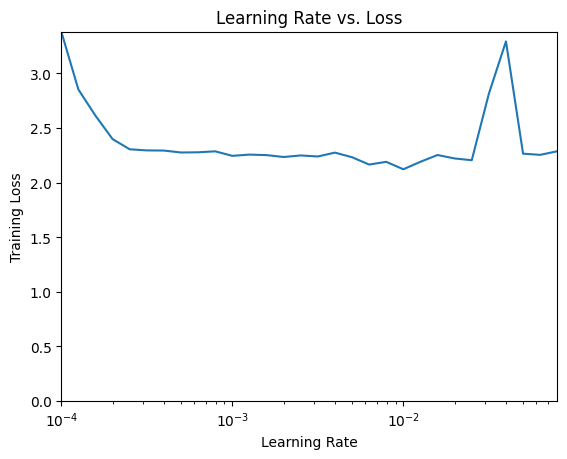

In [19]:
# Plot using the `lrs` list, not history.history['lr']
plt.semilogx(lrs, history.history['loss'])
plt.axis([min(lrs), max(lrs), 0, max(history.history['loss'])])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.title('Learning Rate vs. Loss')
plt.show()

In [20]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
             "best_cnn.keras",
              save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,466 (2.10 MB)

 Trainable params: 551,018 (2.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [22]:
# Fit model in order to make predictions

history = model.fit(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.1081 - loss: 3.8641 - val_accuracy: 0.1133 - val_loss: 2.3034
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.1295 - loss: 2.3694 - val_accuracy: 0.2400 - val_loss: 2.2980
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.1273 - loss: 2.2934 - val_accuracy: 0.1067 - val_loss: 2.2958
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.1514 - loss: 2.3069 - val_accuracy: 0.1000 - val_loss: 2.2960
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.1424 - loss: 2.2732 - val_accuracy: 0.2400 - val_loss: 2.2908
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.1614 - loss: 2.2707 - val_accuracy: 0.2400 - val_loss: 2.2892
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.1654 - loss: 2.2631 - val_accuracy: 0.2400 - val_loss: 2.2845
Epoch 8/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.1847 - loss: 2.2558 - val_accuracy: 0.2400 - val_loss: 2.2701
Epo

In [23]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

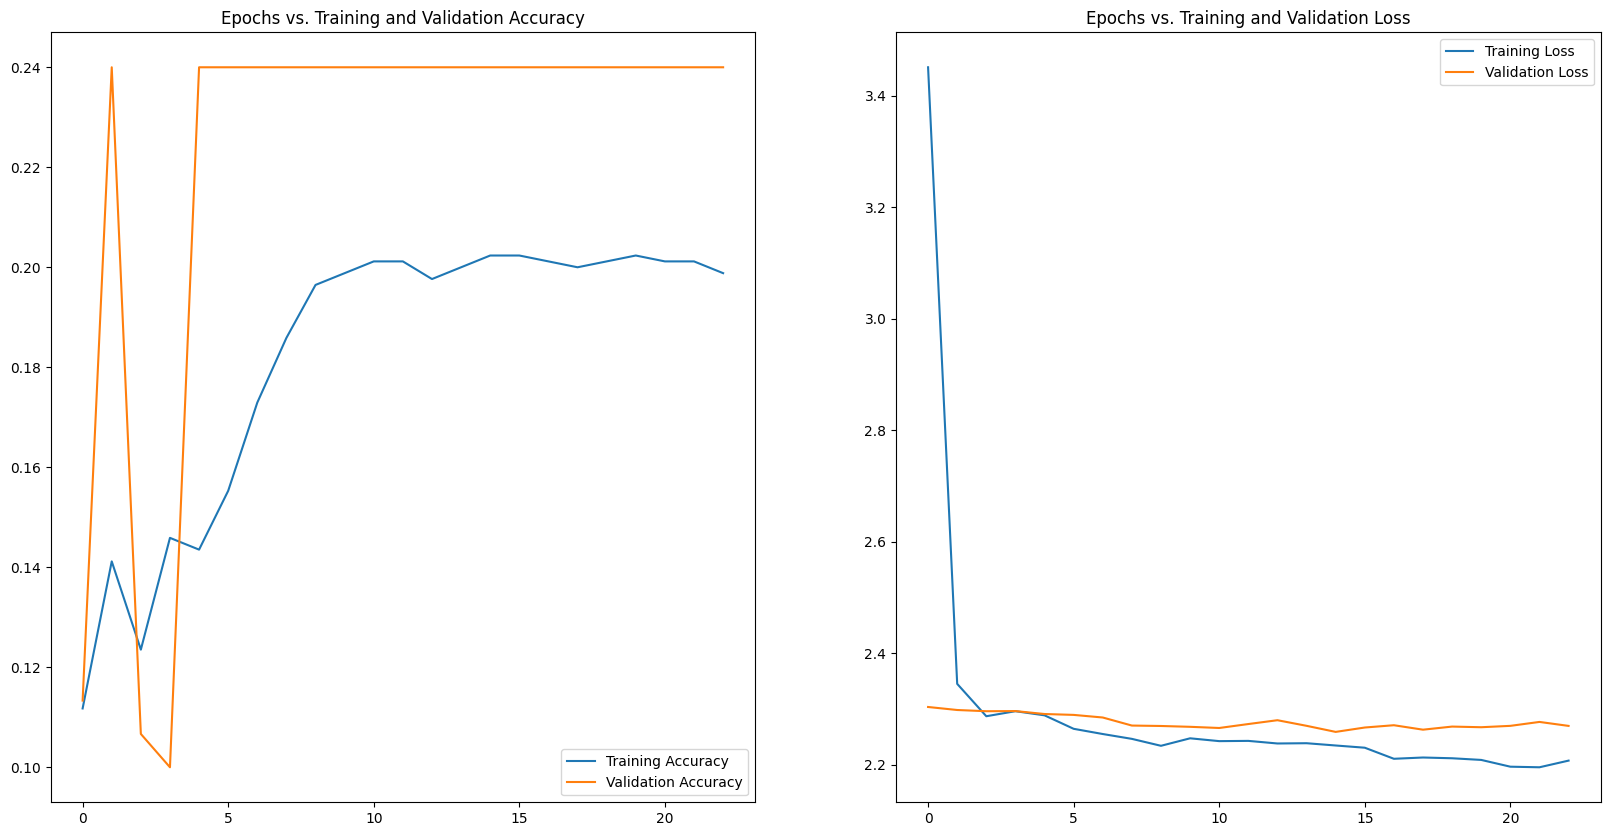

In [24]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [25]:
# Evaluate in batches of 32 samples
test_loss, test_acc = model.evaluate(
    x=test_images,
    y=test_labels,
    batch_size=32,   # <-- explicitly limit how many images at once
    verbose=1
)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss:     {test_loss:.4f}")




814/814 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.1952 - loss: 2.2741
Test accuracy: 0.1959
Test loss:     2.2739


In [26]:
# Get predictions and apply inverse transformation to the labels

y_pred = model.predict(X_train)

y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_train = lb.inverse_transform(y_train, lb.classes_)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


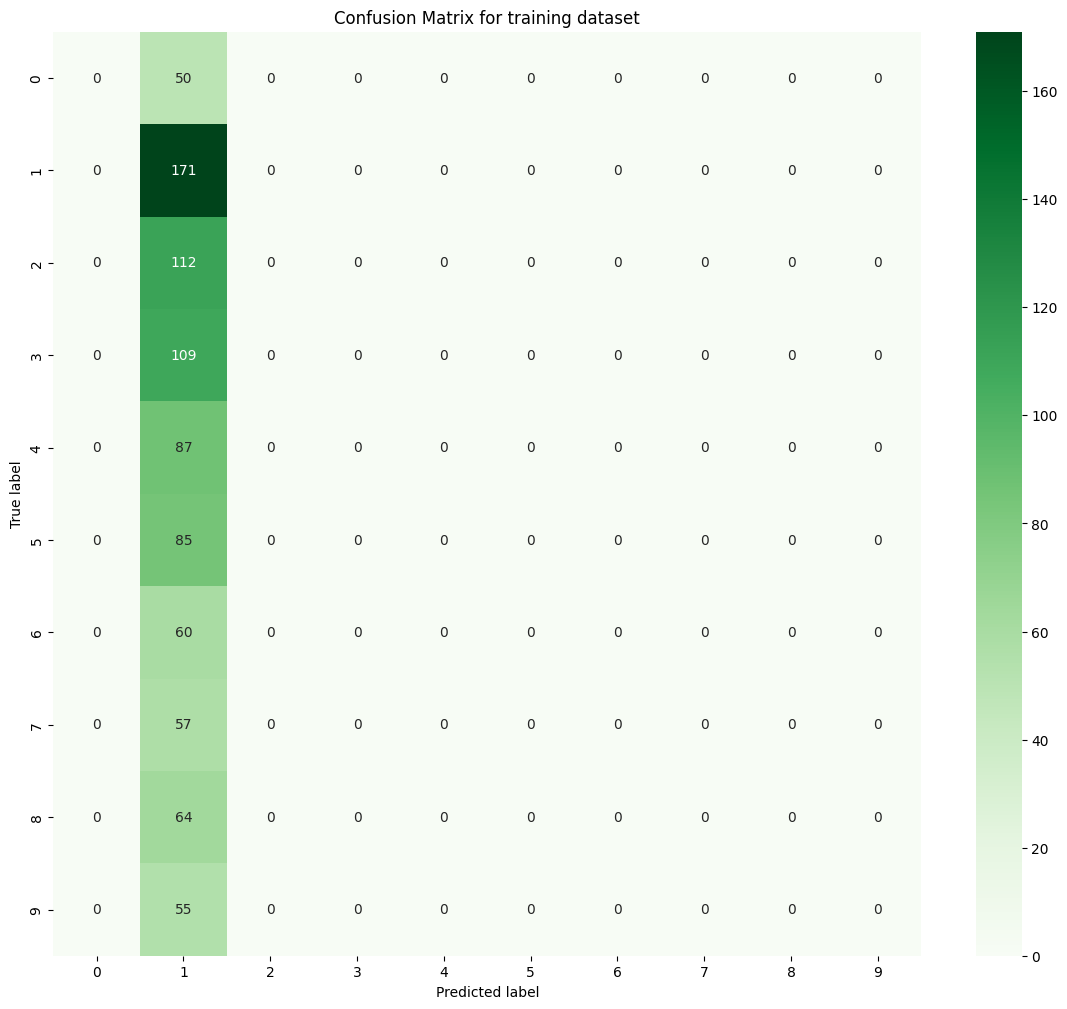

In [27]:
# Plot the confusion matrix

matrix = confusion_matrix(y_train, y_pred, labels=lb.classes_)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(matrix, annot=True, cmap='Greens', fmt='d', ax=ax)
plt.title('Confusion Matrix for training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [28]:
# Ignore the errors in the plots

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [29]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    # … your other layers …
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax'),
])

optimizer = Adam(learning_rate=1e-3, amsgrad=True)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




In [30]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D

# 1) find all your conv layers
conv_layers   = [l for l in model.layers if isinstance(l, Conv2D)]
layer_outputs = [l.output for l in conv_layers]

# 2) grab the input tensor from the very first layer
input_tensor = model.layers[0].input

# 3) build your activation model
activation_model = Model(inputs=input_tensor, outputs=layer_outputs)



In [31]:
# If you want a plain list of layer names:
layer_names = [layer.name for layer in conv_layers]

print(layer_names)
# → ['conv2d', 'conv2d_1', 'conv2d_2', ...]


['conv2d_6', 'conv2d_7']


In [32]:
# Define a function which will plot the convolutional filters

def plot_convolutional_filters(img):
    
    img = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img)
    images_per_row = 9
    
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

X_train.shape: (850, 32, 32, 3)


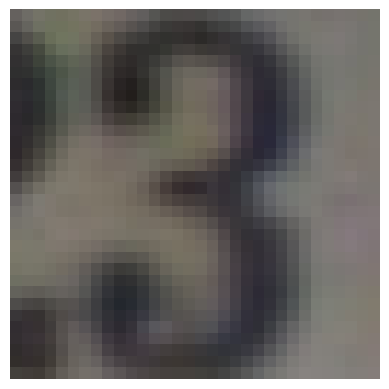

In [34]:
print("X_train.shape:", X_train.shape)
# e.g. pick the 42nd image instead of 42500
img = X_train[41]
plt.imshow(img)
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


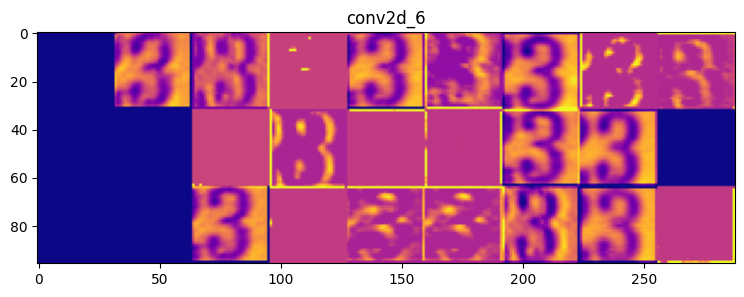

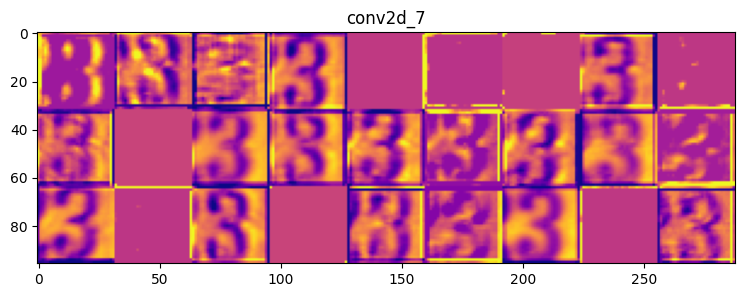

In [35]:
plot_convolutional_filters(img)
